# 1a. Company Financial Data Webscraping Pipeline

Webscraping parent company wikipedia entries to get information from the wiki sidebar on:
- Revenue
- Operating Income
- Net Income 
- Total assets
- Total equity
- Number of emoployees

This information will be joined on parent company to another dataset with GHG emission data. 

In [1]:
import pandas as pd
import numpy as np
import time
import requests
import re
from bs4 import BeautifulSoup as bs
from datetime import date
from fake_useragent import UserAgent
from bs4 import Tag

import pickle

## Pipeline

In [16]:
def get_financial_data(company_list):
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    
    all_financial_data = []
    
    for company in company_list:

        try:
            url = "https://en.wikipedia.org/wiki/{}".format(str(company))

            response  = requests.get(url, headers = user_agent)
            page_html = response.text

            comp_soup = bs(page_html)

            inner_dict = {}
            
            if company == 'Phillips_66':
                ### Revenue
                rev_change = comp_soup.find(text = 'Revenue').next.find('img').get('alt')
                revenue = comp_soup.find(text = 'Revenue').next.find('a').next.next
                
                ### Operating Income
                op_inc_change = comp_soup.find(text = 'Operating income').next.find('img').get('alt')
                operating_income = comp_soup.find(text = 'Operating income').next.find('img').next

                
                ### Net Income
                net_inc_change = comp_soup.find(text = 'Net income').next.find('img').get('alt')
                net_income = comp_soup.find(text = 'Net income').next.find('img').next
                
                ### Total Assets
                assets_change = comp_soup.find(text = 'Total assets').next.find('img').get('alt')
                assets = comp_soup.find(text = 'Total assets').next.find('img').next
                
                ### Total Equity
                equity_change = comp_soup.find(text = 'Total equity').next.find('img').get('alt')
                equity = comp_soup.find(text = 'Total equity').next.find('img').next
                
                ### Employees
                employees = comp_soup.find(text = 'Number of employees').next.next
                

                ##############################
                # Making dictionary of individual company info
                inner_dict['Company'] = company
                inner_dict['Revenue'] = revenue
                inner_dict['Operating_income'] = operating_income
                inner_dict['Net_income'] = net_income
                inner_dict['Total_assets'] = assets
                inner_dict['Total_equity'] = equity
                inner_dict['Employees'] = employees

                inner_dict['Rev_change'] = rev_change
                inner_dict['Op_inc_change'] = op_inc_change
                inner_dict['Net_inc_change'] = net_inc_change
                inner_dict['Assets_change'] = assets_change
                inner_dict['Equity_change'] = equity_change

                all_financial_data.append(inner_dict)

            else:

                ##############################
                # Revenue
                try:
                    rev_change = comp_soup.find(text = 'Revenue').next.find('img').get('alt')
                    revenue = comp_soup.find(text = 'Revenue').next.find('a').next.next

                    if type(revenue) == Tag:
                        revenue = comp_soup.find(text = 'Revenue').next.find('img').next  

                    if len(revenue) <=4:
                        revenue = comp_soup.find(text = 'Revenue').next.find('span').next

                except AttributeError:
                    try:
                        rev_change = comp_soup.find(text = 'Revenue').next.find('img').get('alt')
                        revenue = comp_soup.find(text = 'Revenue').next.find('img').next

                        if type(revenue) == Tag:
                            revenue = comp_soup.find(text = 'Revenue').next.text
                            
                        if any(char.isnumeric() for char in revenue) == False:
                            revenue = comp_soup.find(text = 'Revenue').next.find('img').next.next.next.next

                    except AttributeError:
                        try:
                            revenue = comp_soup.find(text = 'Revenue').next.next
                            rev_change = 'Not found'

                            if type(revenue) == Tag:
                                revenue = comp_soup.find(text = 'Revenue').next.next.text
                                
                                if any(char.isnumeric() for char in revenue) == False:
                                    revenue = comp_soup.find(text = 'Revenue').next.next.next.next

                        except AttributeError:
                            revenue = 'Not found'
                            rev_change = 'Not found'


                ##############################
                # Operating Income
                try:
                    op_inc_change = comp_soup.find(text = 'Operating income').next.find('img').get('alt')
                    operating_income = comp_soup.find(text = 'Operating income').next.find('span').next

                    if type(operating_income) == Tag:
                            if company == 'BP':
                                operating_income = comp_soup.find(text = 'Operating income').next.text
                            else:
                                operating_income = comp_soup.find(text = 'Operating income').next.find('img').next

                            if len(operating_income) <=3:
                                operating_income = comp_soup.find(text = 'Operating income').next.find('span').text

                except AttributeError:
                    try:
                        operating_income = comp_soup.find(text = 'Operating income').next.find('a').next.next

                        if len(operating_income) <= 3:
                            operating_income = comp_soup.find(text = 'Operating income').next.find('img').next

                    except AttributeError:
                        try:
                            operating_income = comp_soup.find(text = 'Operating income').next.find('img').next
                        except AttributeError:
                            if company == 'Owens_Corning':
                                operating_income = comp_soup.find(text = 'Operating income').next.text
                                op_inc_change = 'Not found'
                            else:
                                operating_income = 'Not found'
                                op_inc_change = 'Not found'       

                    if type(operating_income) == Tag:
                        if company == 'Covanta':
                            operating_income = comp_soup.find(text = 'Operating income').next.next
                            op_inc_change = 'Not found'

                        else:
                            operating_income = comp_soup.find(text = 'Operating income').next.find('img').next

                try:
                    if any(char.isalpha() for char in operating_income) == False:
                        dollar_label = comp_soup.find(text = 'Operating income').next.find('span').next.next
                        operating_income = operating_income + ' ' + dollar_label

                except TypeError:
                    continue

                ##############################
                # Net Income
                try:
                    net_inc_change = comp_soup.find(text = 'Net income').next.find('img').get('alt')
                    try:
                        if company == 'BP':
                            net_income = comp_soup.find(text = 'Net income').next.text
                        else:
                            try:
                                net_income = comp_soup.find(text = 'Net income').next.find('span').next
                            except AttributeError:
                                net_income = comp_soup.find(text = 'Net income').next.find('a').next.next

                                if len(net_income) <= 3:
                                    net_income = comp_soup.find(text = 'Net income').next.find('img').next

                        if type(net_income) == Tag:
                            net_income = comp_soup.find(text = 'Net income').next.find('img').next

                            if len(net_income) < 3:
                                net_income = comp_soup.find(text = 'Net income').next.find('span').text

                    except AttributeError:
                        net_income = comp_soup.find(text = 'Net income').next.find('img').next

                        if type(net_income) == Tag:
                            net_income = comp_soup.find(text = 'Net income').next.text

                except AttributeError:
                    try:
                        net_income = comp_soup.find(text = 'Net income').next
                        if type(net_income) == Tag:
                            net_income = comp_soup.find(text = 'Net income').next.text

                        net_inc_change = 'Not found'
                    except AttributeError:
                        net_income = 'Not found'
                        net_inc_change = 'Not found'

                if any(char.isalpha() for char in net_income) == False:
                            dollar_label = comp_soup.find(text = 'Net income').next.find('span').next.next
                            net_income = net_income + ' ' + dollar_label

                ##############################
                # Total Assets
                try:
                    assets_change = comp_soup.find(text = 'Total assets').next.find('img').get('alt')
                    try:
                        assets = comp_soup.find(text = 'Total assets').next.find('img').next

                        if len(assets) <= 5:
                            assets = comp_soup.find(text = 'Total assets').next.text

                        if len(assets) == 1:
                            try:
                                assets = comp_soup.find(text = 'Total assets').next.find('span').next

                                if type(assets) == Tag:
                                    assets = comp_soup.find(text = 'Total assets').next.find('span').text

                            except AttributeError:
                                assets = comp_soup.find(text = 'Total assets').next.find('a').next.next


                    except AttributeError:
                        comp_soup.find(text = 'Total assets').next.find('img').next


                except AttributeError:
                    try:
                        assets_change = 'Not found'
                        assets = comp_soup.find(text = 'Total assets').next.text
                    except AttributeError:
                        assets_change = 'Not found'
                        assets = 'Not found'

                ##############################
                # Total Equity
                try:
                    if company == 'Apache_Corp':
                        equity = comp_soup.find(text = 'Total equity').next.find('span').next
                        equity_change = comp_soup.find(text = 'Total equity').next.find('img').get('alt')
                        equity_dollar = comp_soup.find(text = 'Total equity').next.find('span').next.next
                        equity = equity + ' ' + equity_dollar
                    else:
                        equity_change = comp_soup.find(text = 'Total equity').next.find('img').get('alt')
                        equity = comp_soup.find(text = 'Total equity').next.find('img').next
                

                    if len(equity) == 1:
                        try:
                            equity = comp_soup.find(text = 'Total equity').next.find('span').next
                        except AttributeError:
                            equity = comp_soup.find(text = 'Total equity').next.find('a').next.next

                except AttributeError:
                    try:
                        equity_change = 'Not found'
                        equity = comp_soup.find(text = 'Total equity').next.text
                    except AttributeError:
                        equity_change = 'Not found'
                        equity = 'Not found'


                ##############################
                # Number of Employees
                try:
                    employees = comp_soup.find(text = 'Number of employees').next.next

                    if type(employees) == Tag:
                        employees = comp_soup.find(text = 'Number of employees').next.next.text

                    if len(employees) < 2:
                        employees = comp_soup.find(text = 'Number of employees').next.find('img').next


                except AttributeError:
                    try:
                        employees = comp_soup.find(text = 'Number of employees').next.next.text
                    except AttributeError:
                        employees = 'Not found'
                        
                
                ##############################
                # Making dictionary of individual company info
                inner_dict['Company'] = company
                inner_dict['Revenue'] = revenue
                inner_dict['Operating_income'] = operating_income
                inner_dict['Net_income'] = net_income
                inner_dict['Total_assets'] = assets
                inner_dict['Total_equity'] = equity
                inner_dict['Employees'] = employees

                inner_dict['Rev_change'] = rev_change
                inner_dict['Op_inc_change'] = op_inc_change
                inner_dict['Net_inc_change'] = net_inc_change
                inner_dict['Assets_change'] = assets_change
                inner_dict['Equity_change'] = equity_change

                all_financial_data.append(inner_dict)

            
        except:
            print(company)
        
    return all_financial_data

In [22]:
def get_financial_values(entry):
    
    # entries have year of reference at the end of the string - list to remove references
    year_str = year_str = ['2020','(2020)','2019','(2019)','2018','(2018)','2017','(2017)',
                           '2016','(2016)','2015''(2015)','(2014)',"(2020')[2]",
                           '(2009)2.3%[3]','(2018)[2]','(2011)','(2010)',
                           '(Fiscal Year Ended 2020)[1]',"(2020)'", '(2020)[6]']
    
    
    if entry == 'Not found':
        return None
    
    else:
        # get currency conversion to USD
        if '€' in entry:
            currency_conv = 1.19
        elif '£' in entry:
            currency_conv = 1.38
        elif 'C$' in entry:
            currency_conv = 0.79
        else:
            currency_conv = 1
        
        #print('Conv: ',currency_conv)
        
        string_list = entry.split()
        new_str_list = []

        multiplier = 1
        
        # get rid of year numbers so only numeric characters are the $ amount
        for word in string_list:
            if word not in year_str:
                new_str_list.append(word)
        
        # check for negative sign representing a loss
        if any(char == '−' for char in entry) == True:
            sign = -1
        else:
            sign = 1
            
        #print('Sign: ', sign)
        
        # get the multiplier to turn string value into int
        if 'billion' in entry:
            multiplier = 1e9
        elif 'Billion' in entry:
            multiplier = 1e9
        elif 'million' in entry:
            multiplier = 1e6
        elif 'Million' in entry:
            multiplier = 1e6
        
        #print('Multiplier: ', multiplier)
        
        # remove all characters but the numbers and change format
        new_str = re.sub("[^-0-9.]",""," ".join(new_str_list))
        if new_str.count('.') > 1:
            new_str = new_str[0:len(new_str)-2]
            
        new_num = float(new_str)
        #print(new_num)
 
        final_num = sign * new_num * multiplier * currency_conv

        return final_num

In [18]:
def get_employees(employees):
    
    if employees == 'Not found':
        return None
    
    else:
        
        string_list = employees.split()

        new_str = string_list[0]
        
        if new_str.isalpha() == True:
            new_str = string_list[1]
        
        if len(new_str) < 3:
            new_str = string_list[1]
        
        emp_str = new_str.replace('~','').replace(',','')
        for char in emp_str:
            if char.isnumeric() == False:
                emp_str = emp_str.replace(char,'')
                
        emp_num = int(emp_str)
        
        return emp_num

## Testing pipeline with 100 most common parent companies 
<font color = gray>**_list from GHG emission notebook_**</font>

In [19]:
top_100_parent = pd.read_csv('csv_dict_files/top_100_parent_dict_all.csv')

top_100_parent = top_100_parent[top_100_parent.Wiki != 'None']
top_100_list = top_100_parent.Wiki.tolist()

In [20]:
top_100_list_scrape = []
for company in top_100_list:
    
    if company == 'Green Plains Inc.' or company == 'Dow Inc.':
        top_100_list_scrape.append(company)
    else:
        top_100_list_scrape.append(company.replace('Inc',''))
        
top_100_list_scrape = [company.strip() for company in top_100_list_scrape]
top_100_list_scrape = [company.replace(' ','_') for company in top_100_list_scrape]
top_100_list_scrape[0:10]

['Air_Products_&_Chemicals',
 'Alliant_Energy_Corp',
 'Ameren_Corp',
 'American_Electric_Power',
 'Anheuser-Busch',
 'ANR_Pipeline',
 'Apache_Corp',
 'ArcelorMittal',
 'ADM_(company)',
 'Atmos_Energy_Corp']

In [21]:
ua = UserAgent()
user_agent = {'User-agent': ua.random}
count = 0

for company in top_100_list_scrape:
    url = "https://en.wikipedia.org/wiki/{}".format(str(company))

    response  = requests.get(url, headers = user_agent)
    status_code = response.status_code
    
    if status_code != 200:
        print(company)
        count += 1
        
print(count)

0


In [24]:
company_financials = get_financial_data(top_100_list_scrape)
financial_df = pd.DataFrame.from_dict(company_financials)
financial_df[:10]

,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees,Rev_change,Op_inc_change,Net_inc_change,Assets_change,Equity_change
0,Air_Products_&_Chemicals,US$8.856 billion,US$2.144 billion,US$1.931 billion,US$25.169 billion (2020)[1],US$12.443 billion,"19,275",Decrease,Increase,Increase,Increase,Increase
1,Alliant_Energy_Corp,3.416 Billion (,740 Million (,624 Million (,US$17.710 Billion (Fiscal Year Ended 31 Decem...,5.888 Billion (,"3,375",Decrease,Decrease,Increase,Increase,Increase
2,Ameren_Corp,5.794 Billion (,1.300 Billion (,0.871 Billion (,US$32.030 Billion (Fiscal Year Ended 31 Decem...,9.080 Billion (,"8,615",Decrease,Increase,Increase,Increase,Increase
3,American_Electric_Power,8.879 Billion (,1.507 Billion (,1.064 Billion (,US$80.757 Billion (Fiscal Year Ended 31 Decem...,20.774 Billion (,"17,666",Decrease,Increase,Increase,Increase,Increase
4,Anheuser-Busch,US$15.588 billion (2018),Not found,US$9.811 billion (2018)[4],Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
5,ANR_Pipeline,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found,Not found
6,Apache_Corp,4.308 billion,Not found,−4.860 billion (2020),US$12.746 billion (2020),−0.645 billion (2020),"3,163 (2020)",Decrease,Not found,Decrease,Decrease,Decrease
7,ArcelorMittal,US$53.27 billion,US$2.110 billion,US$−733 million,US$82.052 billion (2020)[5],US$40.24 billion,"168,000 (2020)",Decrease,Increase,Increase,Decrease,Decrease
8,ADM_(company),64.656 billion,US$1.372 billion,US$1.279 billion,US$43.997 billion,US$19.208 billion,"38,100",Increase,Decrease,Decrease,Increase,Increase
9,Atmos_Energy_Corp,2.821 billion,US$824.099 million,US$601.433 million,US$15.359 billion,US$6.791 billion,"4,628",Decrease,Increase,Increase,Increase,Increase


In [25]:
financial_df['Revenue'] = financial_df.Revenue.apply(get_financial_values)
financial_df['Operating_income'] = financial_df.Operating_income.apply(get_financial_values)
financial_df['Net_income'] = financial_df.Net_income.apply(get_financial_values)
financial_df['Total_assets'] = financial_df.Total_assets.apply(get_financial_values)
financial_df['Total_equity'] = financial_df.Total_equity.apply(get_financial_values)

financial_df['Employees'] = financial_df.Employees.apply(get_employees)
financial_df.head(10)

,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees,Rev_change,Op_inc_change,Net_inc_change,Assets_change,Equity_change
0,Air_Products_&_Chemicals,8.856000e+09,2.144000e+09,1.931000e+09,2.516920e+10,1.244300e+10,19275.0,Decrease,Increase,Increase,Increase,Increase
1,Alliant_Energy_Corp,3.416000e+09,7.400000e+08,6.240000e+08,1.771031e+10,5.888000e+09,3375.0,Decrease,Decrease,Increase,Increase,Increase
2,Ameren_Corp,5.794000e+09,1.300000e+09,8.710000e+08,3.203031e+10,9.080000e+09,8615.0,Decrease,Increase,Increase,Increase,Increase
3,American_Electric_Power,8.879000e+09,1.507000e+09,1.064000e+09,8.075731e+10,2.077400e+10,17666.0,Decrease,Increase,Increase,Increase,Increase
4,Anheuser-Busch,1.558800e+10,NaN,9.811202e+09,NaN,NaN,NaN,Not found,Not found,Not found,Not found,Not found
5,ANR_Pipeline,NaN,NaN,NaN,NaN,NaN,NaN,Not found,Not found,Not found,Not found,Not found
6,Apache_Corp,4.308000e+09,NaN,-4.860000e+09,1.274600e+10,-6.450000e+08,3163.0,Decrease,Not found,Decrease,Decrease,Decrease
7,ArcelorMittal,5.327000e+10,2.110000e+09,-7.330000e+08,8.205220e+10,4.024000e+10,168000.0,Decrease,Increase,Increase,Decrease,Decrease
8,ADM_(company),6.465600e+10,1.372000e+09,1.279000e+09,4.399700e+10,1.920800e+10,38100.0,Increase,Decrease,Decrease,Increase,Increase
9,Atmos_Energy_Corp,2.821000e+09,8.240990e+08,6.014330e+08,1.535900e+10,6.791000e+09,4628.0,Decrease,Increase,Increase,Increase,Increase


In [26]:
financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           82 non-null     object 
 1   Revenue           73 non-null     float64
 2   Operating_income  50 non-null     float64
 3   Net_income        63 non-null     float64
 4   Total_assets      59 non-null     float64
 5   Total_equity      56 non-null     float64
 6   Employees         75 non-null     float64
 7   Rev_change        82 non-null     object 
 8   Op_inc_change     82 non-null     object 
 9   Net_inc_change    82 non-null     object 
 10  Assets_change     82 non-null     object 
 11  Equity_change     82 non-null     object 
dtypes: float64(6), object(6)
memory usage: 7.8+ KB


In [27]:
parent_co_financial_df = financial_df[['Company','Revenue','Operating_income','Net_income',
                                       'Total_assets','Total_equity','Employees']]
parent_co_financial_df

,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,Air_Products_&_Chemicals,8.856000e+09,2.144000e+09,1.931000e+09,2.516920e+10,1.244300e+10,19275.0
1,Alliant_Energy_Corp,3.416000e+09,7.400000e+08,6.240000e+08,1.771031e+10,5.888000e+09,3375.0
2,Ameren_Corp,5.794000e+09,1.300000e+09,8.710000e+08,3.203031e+10,9.080000e+09,8615.0
3,American_Electric_Power,8.879000e+09,1.507000e+09,1.064000e+09,8.075731e+10,2.077400e+10,17666.0
4,Anheuser-Busch,1.558800e+10,NaN,9.811202e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...
77,Waste_Connections,4.920000e+09,NaN,NaN,NaN,NaN,16000.0
78,Waste_Management_(corporation),1.448500e+10,2.636000e+09,1.949000e+09,2.182920e+10,6.019000e+09,42300.0
79,WEC_Energy_Group,7.650000e+09,NaN,NaN,NaN,NaN,8000.0
80,WestRock,1.486000e+10,NaN,NaN,NaN,NaN,51100.0


In [28]:
parent_co_financial_df.describe()

,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
count,7.300000e+01,5.000000e+01,6.300000e+01,5.900000e+01,5.600000e+01,75.000000
mean,3.461946e+10,2.518338e+09,-1.206449e+11,8.826342e+10,3.459059e+10,33845.453333
std,5.139654e+10,1.020249e+10,9.744404e+11,1.310113e+11,6.571052e+10,55269.058473
min,7.500000e+08,-2.945000e+10,-7.732020e+12,1.634000e+09,-6.450000e+08,624.000000
25%,5.794000e+09,7.610248e+08,2.343815e+08,2.113260e+10,6.630250e+09,5061.500000
50%,1.217700e+10,1.896000e+09,1.064000e+09,5.015820e+10,1.516700e+10,12945.000000
75%,3.667000e+10,3.876750e+09,2.145500e+09,9.650000e+10,3.204925e+10,34941.500000
max,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.000000


In [29]:
parent_co_financial_df.sort_values('Revenue', ascending = False).reset_index()

,index,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,12,Berkshire_Hathaway,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.0
1,14,BP,1.835000e+11,-2.174202e+10,-2.073202e+10,2.676500e+11,8.557000e+10,70100.0
2,67,Shell_Petroleum,1.805000e+11,2.290000e+10,2.150000e+10,3.793000e+11,1.585000e+11,86000.0
3,38,Exxon_Mobil_Corp,1.785700e+11,-2.945000e+10,2.244000e+10,3.327500e+11,1.571500e+11,72000.0
4,47,Marathon_Petroleum_Corp,1.230000e+11,3.969000e+09,3.432000e+09,4.904700e+10,1.403300e+10,43800.0
...,...,...,...,...,...,...,...,...
77,41,GenOn_Energy_Holdings,NaN,NaN,NaN,NaN,NaN,NaN
78,42,Green_Plains_Inc.,NaN,NaN,NaN,NaN,NaN,1427.0
79,65,Rockies_Express_Pipeline,NaN,NaN,NaN,NaN,NaN,NaN
80,69,Targa_Resources_Corp,NaN,NaN,NaN,NaN,NaN,2372.0


In [30]:
parent_co_financial_df.sort_values('Operating_income', ascending = False).reset_index()

,index,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,12,Berkshire_Hathaway,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.0
1,67,Shell_Petroleum,1.805000e+11,2.290000e+10,2.150000e+10,3.793000e+11,1.585000e+11,86000.0
2,40,General_Motors,1.224850e+11,6.634000e+09,6.427000e+09,2.351940e+11,4.967700e+10,155000.0
3,30,Enbridge,3.955467e+10,6.525560e+09,4.603330e+09,1.289827e+11,5.217413e+10,11000.0
4,29,DuPont,2.157000e+10,5.400000e+09,3.840000e+09,1.880320e+11,9.457000e+10,98000.0
...,...,...,...,...,...,...,...,...
77,69,Targa_Resources_Corp,NaN,NaN,NaN,NaN,NaN,2372.0
78,76,TXU_Energy,NaN,NaN,NaN,NaN,NaN,1000.0
79,77,Waste_Connections,4.920000e+09,NaN,NaN,NaN,NaN,16000.0
80,79,WEC_Energy_Group,7.650000e+09,NaN,NaN,NaN,NaN,8000.0


In [31]:
parent_co_financial_df.sort_values('Net_income', ascending = False).reset_index()

,index,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,12,Berkshire_Hathaway,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.0
1,38,Exxon_Mobil_Corp,1.785700e+11,-2.945000e+10,2.244000e+10,3.327500e+11,1.571500e+11,72000.0
2,67,Shell_Petroleum,1.805000e+11,2.290000e+10,2.150000e+10,3.793000e+11,1.585000e+11,86000.0
3,10,BASF,7.058604e+10,4.821880e+09,1.002099e+10,1.034705e+11,5.039650e+10,117628.0
4,4,Anheuser-Busch,1.558800e+10,NaN,9.811202e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
77,69,Targa_Resources_Corp,NaN,NaN,NaN,NaN,NaN,2372.0
78,76,TXU_Energy,NaN,NaN,NaN,NaN,NaN,1000.0
79,77,Waste_Connections,4.920000e+09,NaN,NaN,NaN,NaN,16000.0
80,79,WEC_Energy_Group,7.650000e+09,NaN,NaN,NaN,NaN,8000.0


In [32]:
parent_co_financial_df.sort_values('Total_assets', ascending = False).reset_index()

,index,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,12,Berkshire_Hathaway,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.0
1,67,Shell_Petroleum,1.805000e+11,2.290000e+10,2.150000e+10,3.793000e+11,1.585000e+11,86000.0
2,38,Exxon_Mobil_Corp,1.785700e+11,-2.945000e+10,2.244000e+10,3.327500e+11,1.571500e+11,72000.0
3,14,BP,1.835000e+11,-2.174202e+10,-2.073202e+10,2.676500e+11,8.557000e+10,70100.0
4,18,Chevron_Corp,9.440000e+10,-7.450000e+09,-5.540000e+09,2.398000e+11,1.327000e+11,42628.0
...,...,...,...,...,...,...,...,...
77,69,Targa_Resources_Corp,NaN,NaN,NaN,NaN,NaN,2372.0
78,76,TXU_Energy,NaN,NaN,NaN,NaN,NaN,1000.0
79,77,Waste_Connections,4.920000e+09,NaN,NaN,NaN,NaN,16000.0
80,79,WEC_Energy_Group,7.650000e+09,NaN,NaN,NaN,NaN,8000.0


In [33]:
parent_co_financial_df.sort_values('Total_equity', ascending = False).reset_index()

,index,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,12,Berkshire_Hathaway,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.0
1,67,Shell_Petroleum,1.805000e+11,2.290000e+10,2.150000e+10,3.793000e+11,1.585000e+11,86000.0
2,38,Exxon_Mobil_Corp,1.785700e+11,-2.945000e+10,2.244000e+10,3.327500e+11,1.571500e+11,72000.0
3,18,Chevron_Corp,9.440000e+10,-7.450000e+09,-5.540000e+09,2.398000e+11,1.327000e+11,42628.0
4,29,DuPont,2.157000e+10,5.400000e+09,3.840000e+09,1.880320e+11,9.457000e+10,98000.0
...,...,...,...,...,...,...,...,...
77,69,Targa_Resources_Corp,NaN,NaN,NaN,NaN,NaN,2372.0
78,76,TXU_Energy,NaN,NaN,NaN,NaN,NaN,1000.0
79,77,Waste_Connections,4.920000e+09,NaN,NaN,NaN,NaN,16000.0
80,79,WEC_Energy_Group,7.650000e+09,NaN,NaN,NaN,NaN,8000.0


In [34]:
parent_co_financial_df.sort_values('Employees', ascending = False).reset_index()

,index,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees
0,12,Berkshire_Hathaway,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.0
1,7,ArcelorMittal,5.327000e+10,2.110000e+09,-7.330000e+08,8.205220e+10,4.024000e+10,168000.0
2,16,Cargill,1.146950e+11,3.204000e+09,3.103000e+09,5.947520e+10,NaN,166000.0
3,40,General_Motors,1.224850e+11,6.634000e+09,6.427000e+09,2.351940e+11,4.967700e+10,155000.0
4,72,Tyson_Foods,4.318500e+10,3.449000e+09,2.061000e+09,3.445600e+10,1.524500e+10,139000.0
...,...,...,...,...,...,...,...,...
77,11,Basin_Electric_Power_Cooperative,NaN,NaN,NaN,NaN,NaN,NaN
78,13,Black_Hills_Corp,1.696000e+09,4.283030e+08,2.427630e+08,8.088312e+09,2.662000e+09,NaN
79,15,Brookfield_Infrastructure_Partners,3.540000e+09,1.100000e+06,5.740000e+08,2.950000e+10,1.350000e+10,NaN
80,41,GenOn_Energy_Holdings,NaN,NaN,NaN,NaN,NaN,NaN


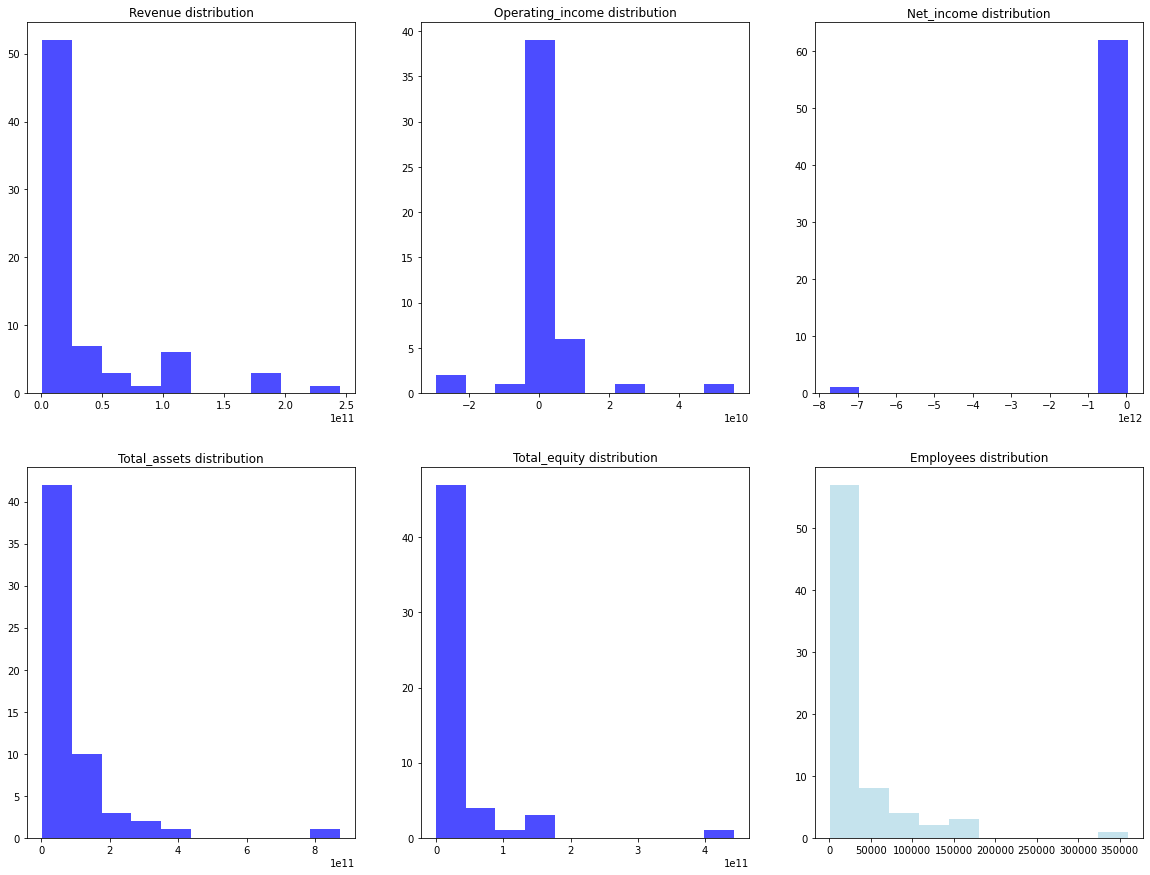

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,15))

plt.subplot(2,3,1)
plt.hist(parent_co_financial_df.Revenue, color = 'blue', alpha = 0.7)
plt.title('Revenue distribution')

plt.subplot(2,3,2)
plt.hist(parent_co_financial_df.Operating_income, color = 'blue', alpha = 0.7)
plt.title('Operating_income distribution')

plt.subplot(2,3,3)
plt.hist(parent_co_financial_df.Net_income, color = 'blue', alpha = 0.7)
plt.title('Net_income distribution')

plt.subplot(2,3,4)
plt.hist(parent_co_financial_df.Total_assets, color = 'blue', alpha = 0.7)
plt.title('Total_assets distribution')

plt.subplot(2,3,5)
plt.hist(parent_co_financial_df.Total_equity, color = 'blue', alpha = 0.7)
plt.title('Total_equity distribution')

plt.subplot(2,3,6)
plt.hist(parent_co_financial_df.Employees, color = 'lightblue', alpha = 0.7)
plt.title('Employees distribution');



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


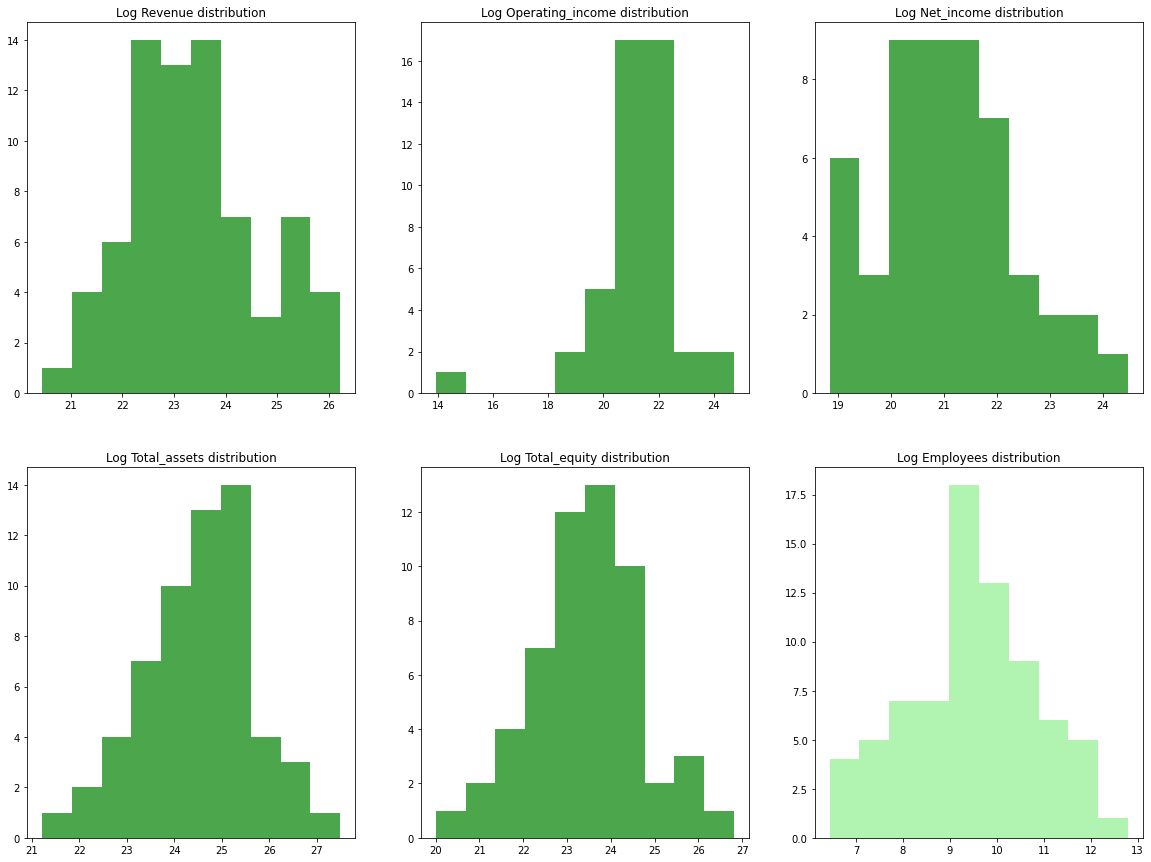

In [36]:
plt.figure(figsize = (20,15))

plt.subplot(2,3,1)
plt.hist(np.log(parent_co_financial_df.Revenue), color = 'green', alpha = 0.7)
plt.title('Log Revenue distribution')

plt.subplot(2,3,2)
plt.hist(np.log(parent_co_financial_df.Operating_income), color = 'green', alpha = 0.7)
plt.title('Log Operating_income distribution')

plt.subplot(2,3,3)
plt.hist(np.log(parent_co_financial_df.Net_income), color = 'green', alpha = 0.7)
plt.title('Log Net_income distribution')

plt.subplot(2,3,4)
plt.hist(np.log(parent_co_financial_df.Total_assets), color = 'green', alpha = 0.7)
plt.title('Log Total_assets distribution')

plt.subplot(2,3,5)
plt.hist(np.log(parent_co_financial_df.Total_equity), color = 'green', alpha = 0.7)
plt.title('Log Total_equity distribution')

plt.subplot(2,3,6)
plt.hist(np.log(parent_co_financial_df.Employees), color = 'lightgreen', alpha = 0.7)
plt.title('Log Employees distribution');

In [37]:
parent_co_financial_df.loc[:,'Log_Revenue'] = np.log(parent_co_financial_df.Revenue)
parent_co_financial_df.loc[:,'Log_Operating_income'] = np.log(parent_co_financial_df.Operating_income)
parent_co_financial_df.loc[:,'Log_Net_income'] = np.log(parent_co_financial_df.Net_income)
parent_co_financial_df.loc[:,'Log_Total_assets'] = np.log(parent_co_financial_df.Total_assets)
parent_co_financial_df.loc[:,'Log_Total_equity'] = np.log(parent_co_financial_df.Total_equity)

parent_co_financial_df.loc[:,'Log_Employees'] = np.log(parent_co_financial_df.Employees)
parent_co_financial_df.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees,Log_Revenue,Log_Operating_income,Log_Net_income,Log_Total_assets,Log_Total_equity,Log_Employees
0,Air_Products_&_Chemicals,8.856000e+09,2.144000e+09,1.931000e+09,2.516920e+10,1.244300e+10,19275.0,22.904361,21.485939,21.381304,23.948887,23.244424,9.866564
1,Alliant_Energy_Corp,3.416000e+09,7.400000e+08,6.240000e+08,1.771031e+10,5.888000e+09,3375.0,21.951736,20.422161,20.251661,23.597413,22.496182,8.124151
2,Ameren_Corp,5.794000e+09,1.300000e+09,8.710000e+08,3.203031e+10,9.080000e+09,8615.0,22.480089,20.985630,20.585153,24.189949,22.929340,9.061260
3,American_Electric_Power,8.879000e+09,1.507000e+09,1.064000e+09,8.075731e+10,2.077400e+10,17666.0,22.906955,21.133387,20.785301,25.114714,23.756968,9.779397
4,Anheuser-Busch,1.558800e+10,NaN,9.811202e+09,NaN,NaN,NaN,23.469767,NaN,23.006791,NaN,NaN,NaN


In [38]:
parent_co_financial_df.describe()

,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees,Log_Revenue,Log_Operating_income,Log_Net_income,Log_Total_assets,Log_Total_equity,Log_Employees
count,7.300000e+01,5.000000e+01,6.300000e+01,5.900000e+01,5.600000e+01,75.000000,73.000000,46.000000,51.000000,59.000000,55.000000,75.000000
mean,3.461946e+10,2.518338e+09,-1.206449e+11,8.826342e+10,3.459059e+10,33845.453333,23.402871,21.244215,21.086085,24.540573,23.481007,9.497239
std,5.139654e+10,1.020249e+10,9.744404e+11,1.310113e+11,6.571052e+10,55269.058473,1.320341,1.586699,1.291760,1.214145,1.270141,1.439285
min,7.500000e+08,-2.945000e+10,-7.732020e+12,1.634000e+09,-6.450000e+08,624.000000,20.435584,13.910821,18.839391,21.214297,20.003775,6.436150
25%,5.794000e+09,7.610248e+08,2.343815e+08,2.113260e+10,6.630250e+09,5061.500000,22.480089,20.777067,20.165520,23.773539,22.712467,8.529344
50%,1.217700e+10,1.896000e+09,1.064000e+09,5.015820e+10,1.516700e+10,12945.000000,23.222815,21.471421,21.064158,24.638448,23.447517,9.468465
75%,3.667000e+10,3.876750e+09,2.145500e+09,9.650000e+10,3.204925e+10,34941.500000,24.325225,22.104797,21.899865,25.292710,24.210144,10.460435
max,2.455000e+11,5.570000e+10,4.250000e+10,8.737000e+11,4.432000e+11,360000.000000,26.226563,24.743246,24.472770,27.496003,26.817287,12.793859


In [39]:
parent_co_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               82 non-null     object 
 1   Revenue               73 non-null     float64
 2   Operating_income      50 non-null     float64
 3   Net_income            63 non-null     float64
 4   Total_assets          59 non-null     float64
 5   Total_equity          56 non-null     float64
 6   Employees             75 non-null     float64
 7   Log_Revenue           73 non-null     float64
 8   Log_Operating_income  46 non-null     float64
 9   Log_Net_income        51 non-null     float64
 10  Log_Total_assets      59 non-null     float64
 11  Log_Total_equity      55 non-null     float64
 12  Log_Employees         75 non-null     float64
dtypes: float64(12), object(1)
memory usage: 8.5+ KB


### Map parent company names back to their GHG data counterpart

In [40]:
parent_co_financial_df['Company'] = parent_co_financial_df['Company'].str.replace('_',' ')
parent_co_financial_df.head()

,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees,Log_Revenue,Log_Operating_income,Log_Net_income,Log_Total_assets,Log_Total_equity,Log_Employees
0,Air Products & Chemicals,8.856000e+09,2.144000e+09,1.931000e+09,2.516920e+10,1.244300e+10,19275.0,22.904361,21.485939,21.381304,23.948887,23.244424,9.866564
1,Alliant Energy Corp,3.416000e+09,7.400000e+08,6.240000e+08,1.771031e+10,5.888000e+09,3375.0,21.951736,20.422161,20.251661,23.597413,22.496182,8.124151
2,Ameren Corp,5.794000e+09,1.300000e+09,8.710000e+08,3.203031e+10,9.080000e+09,8615.0,22.480089,20.985630,20.585153,24.189949,22.929340,9.061260
3,American Electric Power,8.879000e+09,1.507000e+09,1.064000e+09,8.075731e+10,2.077400e+10,17666.0,22.906955,21.133387,20.785301,25.114714,23.756968,9.779397
4,Anheuser-Busch,1.558800e+10,NaN,9.811202e+09,NaN,NaN,NaN,23.469767,NaN,23.006791,NaN,NaN,NaN


In [41]:
company_csv = pd.read_csv('csv_dict_files/parent_co_wiki_to_GHG.csv')
company_dict = pd.Series(company_csv.Parent_co.values, index = company_csv.From).to_dict()
parent_co_financial_df['Company'] = parent_co_financial_df.Company.map(company_dict)
parent_co_financial_df.head(20)

,Company,Revenue,Operating_income,Net_income,Total_assets,Total_equity,Employees,Log_Revenue,Log_Operating_income,Log_Net_income,Log_Total_assets,Log_Total_equity,Log_Employees
0,Air Products & Chemicals Inc,8.856000e+09,2.144000e+09,1.931000e+09,2.516920e+10,1.244300e+10,19275.0,22.904361,21.485939,21.381304,23.948887,23.244424,9.866564
1,Alliant Energy Corp,3.416000e+09,7.400000e+08,6.240000e+08,1.771031e+10,5.888000e+09,3375.0,21.951736,20.422161,20.251661,23.597413,22.496182,8.124151
2,Ameren Corp,5.794000e+09,1.300000e+09,8.710000e+08,3.203031e+10,9.080000e+09,8615.0,22.480089,20.985630,20.585153,24.189949,22.929340,9.061260
3,American Electric Power Co Inc,8.879000e+09,1.507000e+09,1.064000e+09,8.075731e+10,2.077400e+10,17666.0,22.906955,21.133387,20.785301,25.114714,23.756968,9.779397
4,Anheuser-Busch Cos Llc,1.558800e+10,NaN,9.811202e+09,NaN,NaN,NaN,23.469767,NaN,23.006791,NaN,NaN,NaN
5,Anr Pipeline Co,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Apache Corp,4.308000e+09,NaN,-4.860000e+09,1.274600e+10,-6.450000e+08,3163.0,22.183740,NaN,NaN,23.268483,NaN,8.059276
7,Arcelormittal Usa Llc,5.327000e+10,2.110000e+09,-7.330000e+08,8.205220e+10,4.024000e+10,168000.0,24.698639,21.469954,NaN,25.130621,24.418127,12.031719
8,Archer Daniels Midland Co,6.465600e+10,1.372000e+09,1.279000e+09,4.399700e+10,1.920800e+10,38100.0,24.892347,21.039535,20.969344,24.507387,23.678593,10.547970
9,Atmos Energy Corp,2.821000e+09,8.240990e+08,6.014330e+08,1.535900e+10,6.791000e+09,4628.0,21.760357,20.529801,20.214826,23.454967,22.638864,8.439880


In [42]:
parent_co_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               82 non-null     object 
 1   Revenue               73 non-null     float64
 2   Operating_income      50 non-null     float64
 3   Net_income            63 non-null     float64
 4   Total_assets          59 non-null     float64
 5   Total_equity          56 non-null     float64
 6   Employees             75 non-null     float64
 7   Log_Revenue           73 non-null     float64
 8   Log_Operating_income  46 non-null     float64
 9   Log_Net_income        51 non-null     float64
 10  Log_Total_assets      59 non-null     float64
 11  Log_Total_equity      55 non-null     float64
 12  Log_Employees         75 non-null     float64
dtypes: float64(12), object(1)
memory usage: 8.5+ KB


In [43]:
parent_co_financial_df.to_pickle('parent_co_financial_df.pkl')

In [44]:
parent_co_slim = parent_co_financial_df.drop(columns = ['Log_Revenue','Log_Operating_income','Log_Net_income',
                                                       'Log_Total_assets','Log_Total_equity','Log_Employees'])
parent_co_slim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           82 non-null     object 
 1   Revenue           73 non-null     float64
 2   Operating_income  50 non-null     float64
 3   Net_income        63 non-null     float64
 4   Total_assets      59 non-null     float64
 5   Total_equity      56 non-null     float64
 6   Employees         75 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.6+ KB


In [45]:
parent_co_slim.to_pickle('parent_co_slim.pkl')